In [1]:
# Necessary imports
import warnings
warnings.filterwarnings('ignore')
import re
import os
import numpy as np
import scipy as sp
from scipy.sparse import csr_matrix
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from active_tester import ActiveTester
from active_tester.estimators.learned import Learned
from active_tester.estimators.naive import Naive
from active_tester.query_strategy.noisy_label_uncertainty import LabelUncertainty
from active_tester.query_strategy.classifier_uncertainty import ClassifierUncertainty
from active_tester.query_strategy.MCM import MCM
from active_tester.query_strategy.random import Random
from sklearn.metrics import accuracy_score
from active_tester.label_estimation.methods import oracle_one_label, no_oracle, oracle_multiple_labels

# Active Testing Using Text Data 

This is an example of using the ActT library with a text dataset. To walk through this example, download __[a sentiment analysis dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/00331/)__ from the UCI machine learning repository and place the contents in the text_data directory. Additionally, this tutorial follows Scikit Learn's steps on __[Working with Text Data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)__. Before we employ ActT, using the example dataset, we must preprocess the data to create textfiles for each sentence and to divide the dataset into a train and test set.

## Data Processing

Using the preprocessing scripts below, we will combine all of the files into one file containing all 3000 sentence. Then, we will separate the sentences into a test and training set containing the individual sentences as files, then place them in their respective class folders. 

After the dataset is created, set `create_datasets` to `False` to avoid creating duplicate files.

In [2]:
create_datasets = False
# get rid of temporary files inserted to preserve directory structure
if create_datasets:
    myfile = 'text_data/temp.txt'
    if os.path.isfile(myfile):
        os.remove(myfile)
    myfile = 'train/positive/temp.txt'
    if os.path.isfile(myfile):
        os.remove(myfile)
    myfile = 'train/negative/temp.txt'
    if os.path.isfile(myfile):
        os.remove(myfile)
    myfile = 'test/positive/temp.txt'
    if os.path.isfile(myfile):
        os.remove(myfile)
    myfile = 'test/negative/temp.txt'
    if os.path.isfile(myfile):
        os.remove(myfile)

In [3]:
if create_datasets:
    #Combine all sentence files into one file
    try:
        sentences = open('sentences.txt', 'a')
       #Renamed files with dashes
        filenames = ['text_data/imdb_labelled.txt', 
                    'text_data/amazon_cells_labelled.txt', 
                    'text_data/yelp_labelled.txt']
        for filename in filenames:
            print(filename)
            with open(filename) as file:
                for line in file:
                    line = line.rstrip()
                    sentences.write(line + '\n')
    except Exception:
        print('File not found')

In [4]:
if create_datasets:
    #Separate sentences into a test and training set
    #Write each sentence to a file and place that file in its respective class folder
    filename = 'sentences.txt'
    with open(filename) as file:
        count = 1
        for line in file:
            if count <= 2000:
                line = line.rstrip()
                if line[-1:] == '0':
                    input_file = open('train/negative/inputfile-' + str(count) + '.txt', 'a')
                    line = line[:-1]
                    line = line.rstrip()
                    input_file.write(line)
                if line[-1:] == '1':
                    input_file = open('train/positive/inputfile-' + str(count) + '.txt', 'a')
                    line = line[:-1]
                    line = line.rstrip()
                    input_file.write(line)
            if count > 2000:
                line = line.rstrip()
                if line[-1:] == '0':
                    input_file = open('test/negative/inputfile-' + str(count) + '.txt', 'a')
                    line = line[:-1]
                    line = line.rstrip()
                    input_file.write(line)
                if line[-1:] == '1':
                    input_file = open('test/positive/inputfile-' + str(count) + '.txt', 'a')
                    line = line[:-1]
                    line = line.rstrip()
                    input_file.write(line)
            count = count + 1

## Loading Data and Training a Model

Below, we load the training data, create term frequency features, and then fit a classifier to the data.

In [5]:
#Load training data from files
categories = ['positive', 'negative']
sent_data = datasets.load_files(container_path='train', categories=categories, shuffle=True)
X_train, y_train = sent_data.data, sent_data.target

#Extract features
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#Transform occurance matrix to a frequency matrix
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)

#Build a classifier
clf = MultinomialNB().fit(X_train_tf, sent_data.target)

Now, we transform the test dataset to use the same features, apply the classifier to the test dataset and compute the classifier's true accuracy. 

In [6]:
#Load the test data from files
sent_data_test = datasets.load_files(container_path='test', categories=categories, shuffle=False)
X_test, y_test = sent_data_test.data, sent_data_test.target

#Extract features
X_test_counts = count_vect.transform(sent_data_test.data)

#Transform occurance matrix to a frequency matrix
X_test_tf = tf_transformer.transform(X_test_counts)

#Compute the true accuracy of the classifier
label_predictions = clf.predict(X_test_tf)
true_accuracy = accuracy_score(y_test, label_predictions)

## Using Active Tester

The following code creates a set of noisy labels, reshapes the true labels, and converts the test features to a dense array.

In [7]:
#Initialize key variables: X, Y_noisy, and vetted
Y_noisy = []
noisy_label_accuracy = 0.75
for i in range(len(y_test)):
    if np.random.rand() < noisy_label_accuracy:
        # noisy label is correct
        Y_noisy.append(y_test[i])
    else:
        # noisy label is incorrect
        Y_noisy.append(np.random.choice(np.delete(np.arange(2),y_test[i])))
Y_noisy = np.asarray(Y_noisy, dtype=int)
#Note that if your y_noisy array is shape (L,), you will need to reshape it to be (L,1)
Y_noisy = np.reshape(Y_noisy,(len(Y_noisy),1))

Y_ground_truth = np.reshape(y_test, (len(y_test), 1))

#Note that if using sklearn's transformer, you may recieve an error about a sparse
#matrix. Using scipy's sparse csr_matrix.toarray() method can resolve this issue
X = csr_matrix.toarray(X_test_tf)

Now to display the sentences to the vetter in an interactive session, we need to create a list of all the test data files.  This will serve as raw input to the `query_vetted` method of `active_tester`.  

In [8]:
#Create a list with all of the test data files to serve as the raw input to query vetted
file_list = []
sentence_dirs = os.path.join(os.getcwd(),'test')
for root, dirs, files in os.walk(sentence_dirs):
    for name in files:
        if name.endswith('.txt'):
            local_path = os.path.join(root, name)
            file_list.append(os.path.join(sentence_dirs, local_path))

Now, we are ready to estimate the performance of the classifier by querying the oracle.

In [9]:
#Active Tester with a Naive Estimator, Classifier Uncertainty Query Method, and Interactive Query Vetting
budget = 5

active_test = ActiveTester(Naive(metric=accuracy_score), 
                                         ClassifierUncertainty())
active_test.standardize_data(X=X, 
                             classes=sent_data.target_names,
                             Y_noisy=Y_noisy)

active_test.gen_model_predictions(clf)
active_test.query_vetted(True, budget, raw=file_list)
active_test.test()
results = active_test.get_test_results()

There may be a mismatch between the ordering of the vetted labels and the items. Please set rearragne to False
Beginning preprocessing to find vetted labels of each class...
"
Great place to relax and have an awesome burger and beer.
"


The available labels are: ['negative', 'positive']
Label the provided item: positive


"
The grilled chicken was so tender and yellow from the saffron seasoning.
"


The available labels are: ['negative', 'positive']
Label the provided item: positive


"
Some highlights : Great quality nigiri here!
"


The available labels are: ['negative', 'positive']
Label the provided item: positive


"
Stopped by this place while in Madison for the Ironman, very friendly, kind staff.
"


The available labels are: ['negative', 'positive']
Label the provided item: positive


"
Very convenient, since we were staying at the MGM!
"


The available labels are: ['negative', 'positive']
Label the provided item: positive


Completed preprocessing
Budget reduced from "5" to 

In [10]:
# View the result and compare to the true accuracy
print('Test metric with budget of', budget,': ', results['tester_metric'])
print('True accuracy of classifier: ', true_accuracy)

Test metric with budget of 5 :  0.6368715083798883
True accuracy of classifier:  0.7620111731843575


## A Comparison of Query Strategies and Estimators

Below, we compare a couple of query strategies and estimators.

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "98"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "200" to "198"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "298"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "398"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "498"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "98"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "200" to "198"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "298"
Beginning preprocessing to

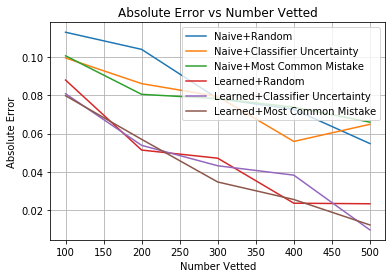

In [11]:
import matplotlib.pyplot as plt

abs_error_array = []

# Initialize the estimators
learned = Learned(metric=accuracy_score, estimation_method=oracle_multiple_labels)
naive = Naive(metric=accuracy_score)
estimator_list = {'Naive': naive, 'Learned': learned}

# Initialize a few query strategies
rand = Random()
classifier_uncertainty = ClassifierUncertainty()
mcm = MCM(estimation_method=oracle_multiple_labels)

query_strategy_list = {'Random': rand, 'Classifier Uncertainty': classifier_uncertainty, 
                       'Most Common Mistake': mcm}

# Run active testing for each estimator-query pair, for a range of sample sizes
sample_sizes = [100, 200, 300, 400, 500]
for est_k, est_v in estimator_list.items():
    for query_k, query_v in query_strategy_list.items():
        abs_error_array = []
        for i in sample_sizes:

            at = ActiveTester(est_v, query_v)

            #Set dataset and model values in the active tester object
            at.standardize_data(X=X, 
                                classes=sent_data.target_names, 
                                Y_ground_truth=Y_ground_truth, 
                                Y_noisy=Y_noisy)
            at.gen_model_predictions(clf)
            at.query_vetted(False, i)
            at.test()

            results = at.get_test_results()
            abs_error_array.append(np.abs(results['tester_metric'] - true_accuracy))

        plt.ylabel("Absolute Error")
        plt.xlabel("Number Vetted")

        plt.plot(sample_sizes, abs_error_array, label=est_k + '+' + query_k)
        plt.legend(loc='best')
        plt.title('Absolute Error vs Number Vetted')
        plt.grid(True)

plt.show()

As you can see from the graph, the absolute error for the learned estimation method is smaller than for the naive method.  There is not a large difference between the different query strategies.